<a href="https://colab.research.google.com/github/gitudaniel/fastai-course-notes/blob/main/Creating_a_Notebook_app_from_the_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai==2.2.7

     |████████████████████████████████| 194kB 5.5MB/s 
     |████████████████████████████████| 61kB 3.8MB/s 
     |████████████████████████████████| 12.8MB 310kB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
import fastai

In [ ]:
fastai.__version__

'2.2.7'

In [ ]:
import pathlib
from fastai.vision.all import *
from fastai.vision import widgets

# Widgets

- IPython widgets are GUI components that bring together Javascript and Python to give web style functionality to jupyter notebooks

```
widgets.FileUpload()  # Creates a clickable upload button within the jupyter notebook
```

- The `upload` button has a `data` property which is an array containing all the uploaded images. This can be passed to `PILImage.create()`

- `PILImage.create` is smart enough to create an image from all kinds of different things including a `binary blob` which is what a file upload contains.

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

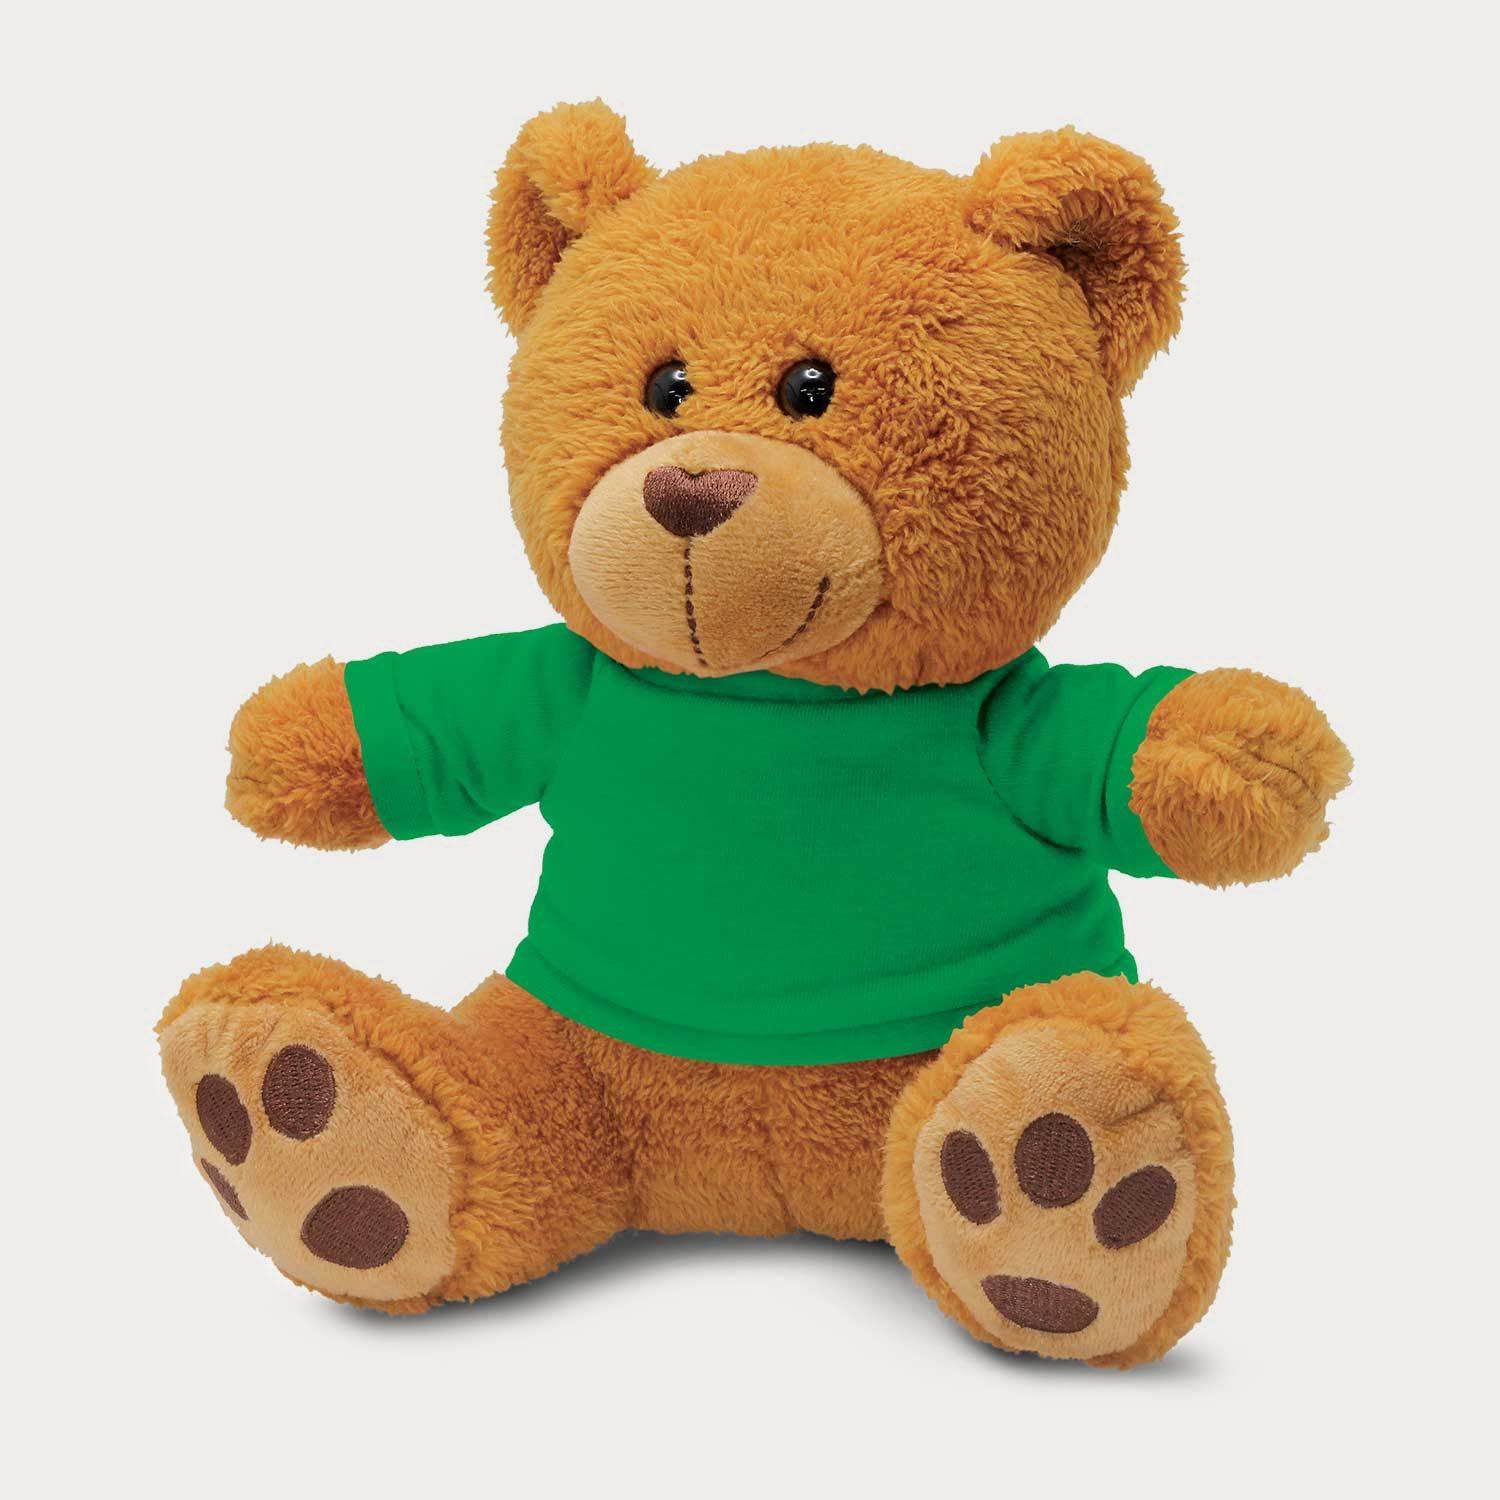

In [ ]:
img = PILImage.create(btn_upload.data[-1])
img

- Below is an alternative approach also for getting widgets

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

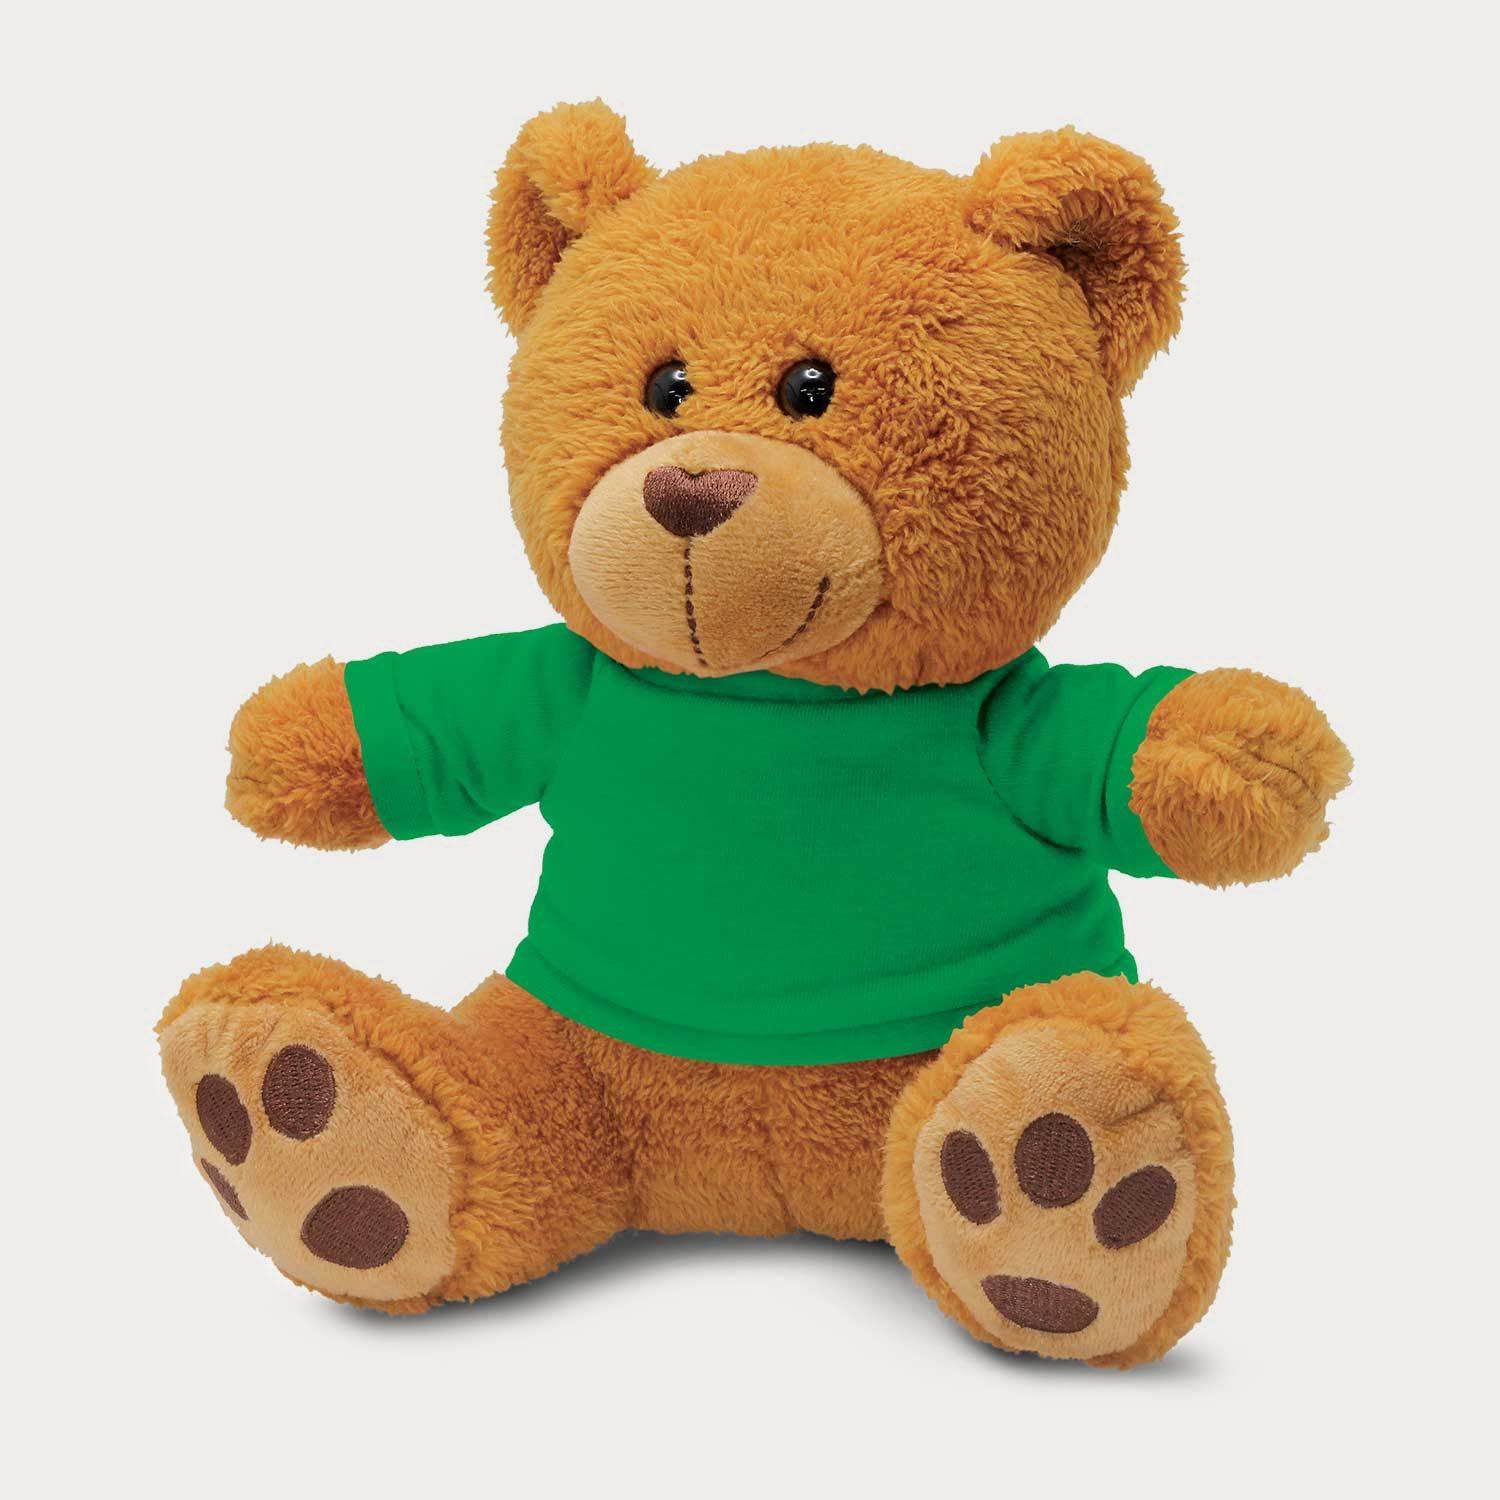

In [ ]:
img = PILImage.create(btn_upload.data[-1])
img

- We can use an `Output` widget to display images.

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

- We can use `Label` to display

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = 'Please choose an image'
lbl_pred

Label(value='Please choose an image')

- We can add a general button and give it a name

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

- The button itself doesn't do anything, but we can attach an event handler to it i.e. a button that will be called when it's pressed.

In [ ]:
MODEL_PATH = 'drive/MyDrive/Colab Notebooks/Fastai/export.pkl'

MODEL_PATH = pathlib.Path(MODEL_PATH)
print(MODEL_PATH.exists())

learn_inf = load_learner(MODEL_PATH)

True


In [ ]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred, pred_idx, probs = learn_inf.predict(img)
  lbl_pred.value= f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

- We can then put all the above together in a `VBox`

- A `VBox` is a vertical box that you can put widgets in

In [ ]:
widgets.VBox

ipywidgets.widgets.widget_box.VBox

In [ ]:
widgets.VBox([widgets.Label('Select your Bear!'),
              btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
pred, pred_idx, probs = learn_inf.predict(img)

In [ ]:
pred

'teddy'

In [ ]:
pred_idx

tensor(2)

In [ ]:
probs

tensor([1.2182e-07, 7.4309e-08, 1.0000e+00])

In [ ]:
probs[pred_idx]

tensor(1.0000)

In [ ]:
print(f'The prediction is {probs[pred_idx]:.04f}')

The prediction is 1.0000


# How to avoid disaster

- Models can only reflect the data used to train them, and the world is full of biased data (Google search for healthy skin shows predominantly young white women touching their face).

- Be sure to think about the types of data that you might expect to see in practice in your application, and check carefully to ensure that all these types are reflected in your model's source data.

- For our bear prediction model, if we were to roll out a bear detection system to warn of incoming bears, the problems we would encounter in practice would be:
  - Working with video data instead of images.
  - Handling nighttime images which might not appear in this dataset.
  - Dealing with low resolution images.
  - Ensuring results are returned fast enough to be useful in practice.
  - Recognising bears in positions rarely seen in photos posted online e.g. from behind, partially obscured by a bush or far away from the camera.

- The photos that people post online do a good job of clearly and artistically displaying their subject matter. We may need to do a lot of our own data collection and labelling to create a useful system.

- This is just one manifestation of `out of domain` data.

- `Out of domain data` - Data that the model sees in production which is very different to what it saw during training.

- `Domain shift` - when the data that our model sees shifts over time e.g. for an insurance company deploying a deep learning model as part of pricing and risk, the type of customers and the risks they represent may change so much over time that the initial training data is no longer relevant.


#### Deployment strategies to mitigate the indescribability of models
- Run the model in parallel with human observation and have a human compare all predictions with what a human being would have chosen.

- When you're confident that the predictions are reasonable when compared to real life scenarios, deploy it in a time and geography limited way with careful human supervision (one campsite)

- Gradual expansion with good reporting systems to catch potential errors and evaluate model performance.

-------------------------------------------
- Compensating for domain shift boils down to a transfer learning problem.
- One of the ways to do this is to take the previous day's transactions in mini-batches and trains another epoch.
- We can call this a `fine-tuning approach` where the pretrained model is yesterday's model and your fine-tuning data is today's data.
--------------------------------------------


# Unforeseen consequences and feedback loops
- Deploying a model might change the behavior of the system it's a part of and this can create a feedback loop.

- Feedback loops are a particular challenge for machine learning models because they can take a small issue and explode it.

- Let's take the example of a predictive policing algorithm.

- Our algorithm may predict more crime in a certain neighborhood causing more police to be sent there which can result in more crime being recorded in those neighborhoods since more police will observe more crime and so on.

- Taking this feedback loop into consideration, predictive policing is aptly named; it is predicting future policing, not future crime (Kristian Lum & William Isaac - [To predict and serve](https://rss.onlinelibrary.wiley.com/doi/epdf/10.1111/j.1740-9713.2016.00960.x))

- Feedback loops can result in negative implications of bias getting worse and worse e.g. in the US there is significant bias in arrest rates on racial grounds; our predictive policing algorithm would only make this worse.

- A helpful exercise prior to rolling out a significant machine learning system is to consider the question:
  - *What would happen if it went really, really well?*
  - *If the predictive power was extremely high and its ability to infuence behavior was extremely significant:*
    - *Who would be the most affected?*
    - *What would the most extreme results potentially look like?*
    - *How would you know what's really going on?*

- Such a thought process might help you construct:
  - a more careful rollout plan
  - ongoing monitoring systems
  - human oversight

- Note that human oversight is only useful if it's listened to so ensure reliable and resilient communication channels so that relevan people are aware of issues and will have the power to fix them.

- Human oversight needs to be closely integrated with product and engineering to ease the flow of communication.

